# <center>Diabetes Disease Detection</center>

## Overview:
Diabetes is a disease that occurs when your blood glucose, also called blood sugar, is too high. Glucose is your body’s main source of energy. Your body can make glucose, but glucose also comes from the food you eat. Insulin is a hormone made by the pancreas that helps glucose get into your cells to be used for energy. If you have diabetes, your body doesn’t make enough—or any—insulin, or doesn’t use insulin properly. Glucose then stays in your blood and doesn’t reach your cells. Diabetes raises the risk for damage to the eyes, kidneys, nerves, and heart. Diabetes is also linked to some types of cancer.

## Dataset Information:
PIMA Indian Dataset: [Kaggle - Diabetes Disease Detection](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

### Independent Feature:
* Outcome

### Dependent Feature:
* Pregnancies	
* Glucose	
* BloodPressure	
* SkinThickness	
* Insulin	
* BMI	
* DiabetesPedigreeFunction	
* Age

### Training : Testing :: 800 : 200 :: 80 : 20

# Importing required libraries

In [30]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
df = pd.read_csv('Data/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# Data Sampling

In [3]:
df["Outcome"].value_counts()

class_0 = df[df["Outcome"]==0]
class_1 = df[df["Outcome"]==1]

In [4]:
class_0

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85,66,29,0,26.6,0.351,31,0
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
762,9,89,62,0,0,22.5,0.142,33,0
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0


In [5]:
class_1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
2,8,183,64,0,0,23.3,0.672,32,1
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
...,...,...,...,...,...,...,...,...,...
755,1,128,88,39,110,36.5,1.057,37,1
757,0,123,72,0,0,36.3,0.258,52,1
759,6,190,92,0,0,35.5,0.278,66,1
761,9,170,74,31,0,44.0,0.403,43,1


In [6]:
df_n = class_1.sample(500, replace=True)

df = pd.concat([class_0, df_n], axis=0)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85,66,29,0,26.6,0.351,31,0
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
648,11,136,84,35,130,28.3,0.260,42,1
709,2,93,64,32,160,38.0,0.674,23,1
402,5,136,84,41,88,35.0,0.286,35,1
709,2,93,64,32,160,38.0,0.674,23,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 17
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               1000 non-null   int64  
 1   Glucose                   1000 non-null   int64  
 2   BloodPressure             1000 non-null   int64  
 3   SkinThickness             1000 non-null   int64  
 4   Insulin                   1000 non-null   int64  
 5   BMI                       1000 non-null   float64
 6   DiabetesPedigreeFunction  1000 non-null   float64
 7   Age                       1000 non-null   int64  
 8   Outcome                   1000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 78.1 KB


In [8]:
features = df.columns
features

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,4.207000,126.028000,69.9190,21.122000,86.636000,32.60880,0.485156,34.120000,0.50000
std,3.500915,33.664083,19.2445,16.229495,118.437168,7.61387,0.316993,11.598367,0.50025
min,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.078000,21.000000,0.00000
25%,1.000000,102.000000,64.0000,0.000000,0.000000,27.80000,0.251750,24.750000,0.00000
50%,3.000000,123.000000,72.0000,24.000000,40.000000,32.80000,0.389000,31.000000,0.50000
75%,7.000000,149.000000,80.0000,33.000000,144.000000,36.90000,0.665250,42.000000,1.00000
max,17.000000,199.000000,122.0000,99.000000,744.000000,67.10000,2.329000,81.000000,1.00000


# Data Preprocessing

In [10]:
categorical_columns = []
numerical_columns = []

for col in df.columns:
    if df[col].dtype == 'object':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

In [11]:
print("Numerical Features: ",numerical_columns)

print("\nCategorical Features: ",categorical_columns)

Numerical Features:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Categorical Features:  []


In [12]:
discrete_features=[feature for feature in numerical_columns if len(df[feature].unique())<25]
continuous_features=[feature for feature in numerical_columns if feature not in discrete_features]

In [13]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

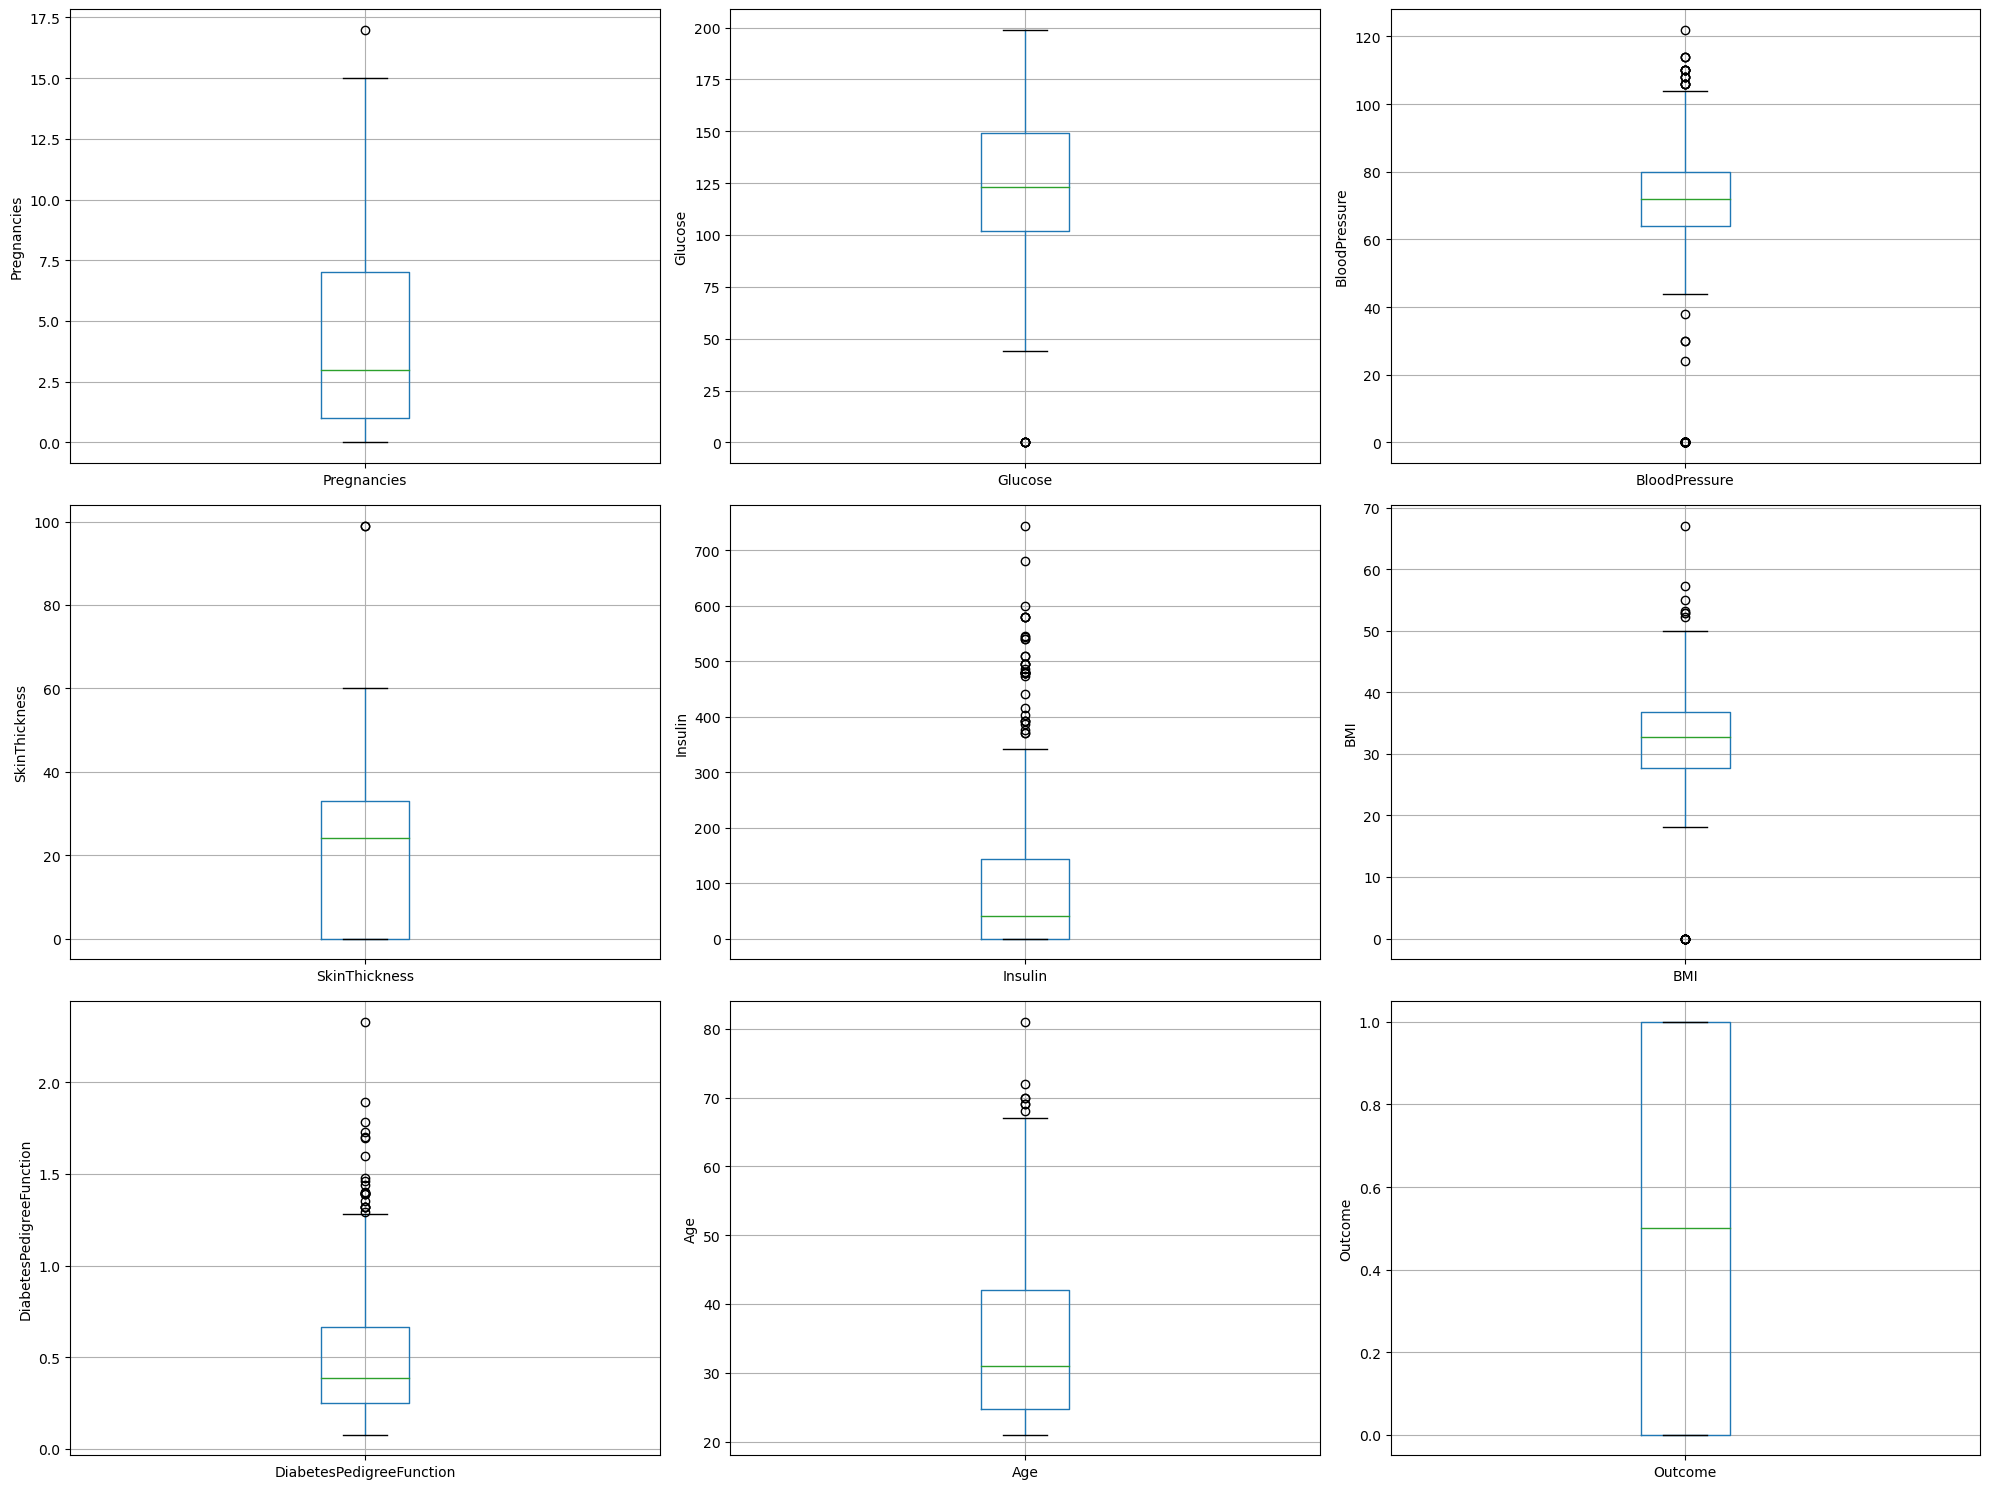

In [14]:
fig, axes = plt.subplots(3,3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    df.boxplot(column=col, ax=ax)
    ax.set_ylabel(col)

for j in range(len(df.columns), 3,3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
for feature in continuous_features:
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_limit = df[feature].quantile(0.25) - (IQR * 3)
    upper_limit = df[feature].quantile(0.75) + (IQR * 3)
    df.loc[df[feature] >= upper_limit, feature] = upper_limit
    df.loc[df[feature] < lower_limit, feature] = lower_limit

In [16]:
x =  df.drop(columns=['Outcome'],axis=1)
y = df['Outcome']

In [17]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [18]:
x_train, x_test, y_train, y_test =train_test_split(x,y,test_size=0.20,random_state=40,stratify=df['Outcome'])

# Modelling

In [19]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=20, max_depth=10),
    'XG Boost': XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15, gamma=0.6, subsample=0.52, colsample_bytree=0.6, seed=27,
                              reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5),
    'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=6),
    'Support Vector Machine': SVC(kernel='rbf', C=2, probability=True),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier()
}

In [20]:
model_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for model_name, model in models.items():

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print("Testing Accuracy: ", test_accuracy)
    print("Precision: ",precision)
    print("Recall: ",recall)
    print("F1 Score: ",f1)


    model_list.append(model_name)
    accuracy_list.append(test_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print("=" * 35)

max_accuracy_index = accuracy_list.index(max(accuracy_list))
print(f"The best model based on accuracy is {model_list[max_accuracy_index]} with Testing Accuracy: {accuracy_list[max_accuracy_index]}")

Model: Logistic Regression
Testing Accuracy:  0.71
Precision:  0.7019230769230769
Recall:  0.73
F1 Score:  0.7156862745098039
Model: Naive Bayes
Testing Accuracy:  0.71
Precision:  0.7282608695652174
Recall:  0.67
F1 Score:  0.6979166666666667
Model: Random Forest Classifier
Testing Accuracy:  0.845
Precision:  0.8
Recall:  0.92
F1 Score:  0.8558139534883721
Model: XG Boost
Testing Accuracy:  0.755
Precision:  0.7217391304347827
Recall:  0.83
F1 Score:  0.772093023255814
Model: K Nearest Neighbors
Testing Accuracy:  0.72
Precision:  0.7291666666666666
Recall:  0.7
F1 Score:  0.7142857142857142
Model: Decision Tree
Testing Accuracy:  0.76
Precision:  0.7241379310344828
Recall:  0.84
F1 Score:  0.7777777777777777
Model: Support Vector Machine
Testing Accuracy:  0.775
Precision:  0.7835051546391752
Recall:  0.76
F1 Score:  0.7715736040609137
Model: AdaBoost Classifier
Testing Accuracy:  0.76
Precision:  0.7549019607843137
Recall:  0.77
F1 Score:  0.7623762376237624
Model: Gradient Boostin

# Hyperparamter Tuning

In [21]:
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest Classifier': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
    'XG Boost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100], 'max_depth': [10, 15]},
    'K Nearest Neighbors': {'n_neighbors': [5, 10, 15]},
    'Decision Tree': {'max_depth': [5, 10]},
    'Support Vector Machine': {'C': [1, 10]},
    'AdaBoost Classifier': {'n_estimators': [50, 100]},
    'Gradient Boosting Classifier': {'n_estimators': [50, 100]},
    'Extra Trees Classifier': {'n_estimators': [50, 100]}
}

In [22]:
best_model = None
best_accuracy = 0

for model_name, model in models.items():
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_model_cv = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {model_name}: {best_params}")
        y_pred = best_model_cv.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy on test set for {model_name}: {accuracy}\n")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = best_model_cv

Best parameters for Logistic Regression: {'C': 1}
Accuracy on test set for Logistic Regression: 0.71

Best parameters for Random Forest Classifier: {'max_depth': 10, 'n_estimators': 100}
Accuracy on test set for Random Forest Classifier: 0.835

Best parameters for XG Boost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Accuracy on test set for XG Boost: 0.765

Best parameters for K Nearest Neighbors: {'n_neighbors': 5}
Accuracy on test set for K Nearest Neighbors: 0.745

Best parameters for Decision Tree: {'max_depth': 10}
Accuracy on test set for Decision Tree: 0.81

Best parameters for Support Vector Machine: {'C': 10}
Accuracy on test set for Support Vector Machine: 0.77

Best parameters for AdaBoost Classifier: {'n_estimators': 100}
Accuracy on test set for AdaBoost Classifier: 0.735

Best parameters for Gradient Boosting Classifier: {'n_estimators': 50}
Accuracy on test set for Gradient Boosting Classifier: 0.785

Best parameters for Extra Trees Classifier: {'n_esti

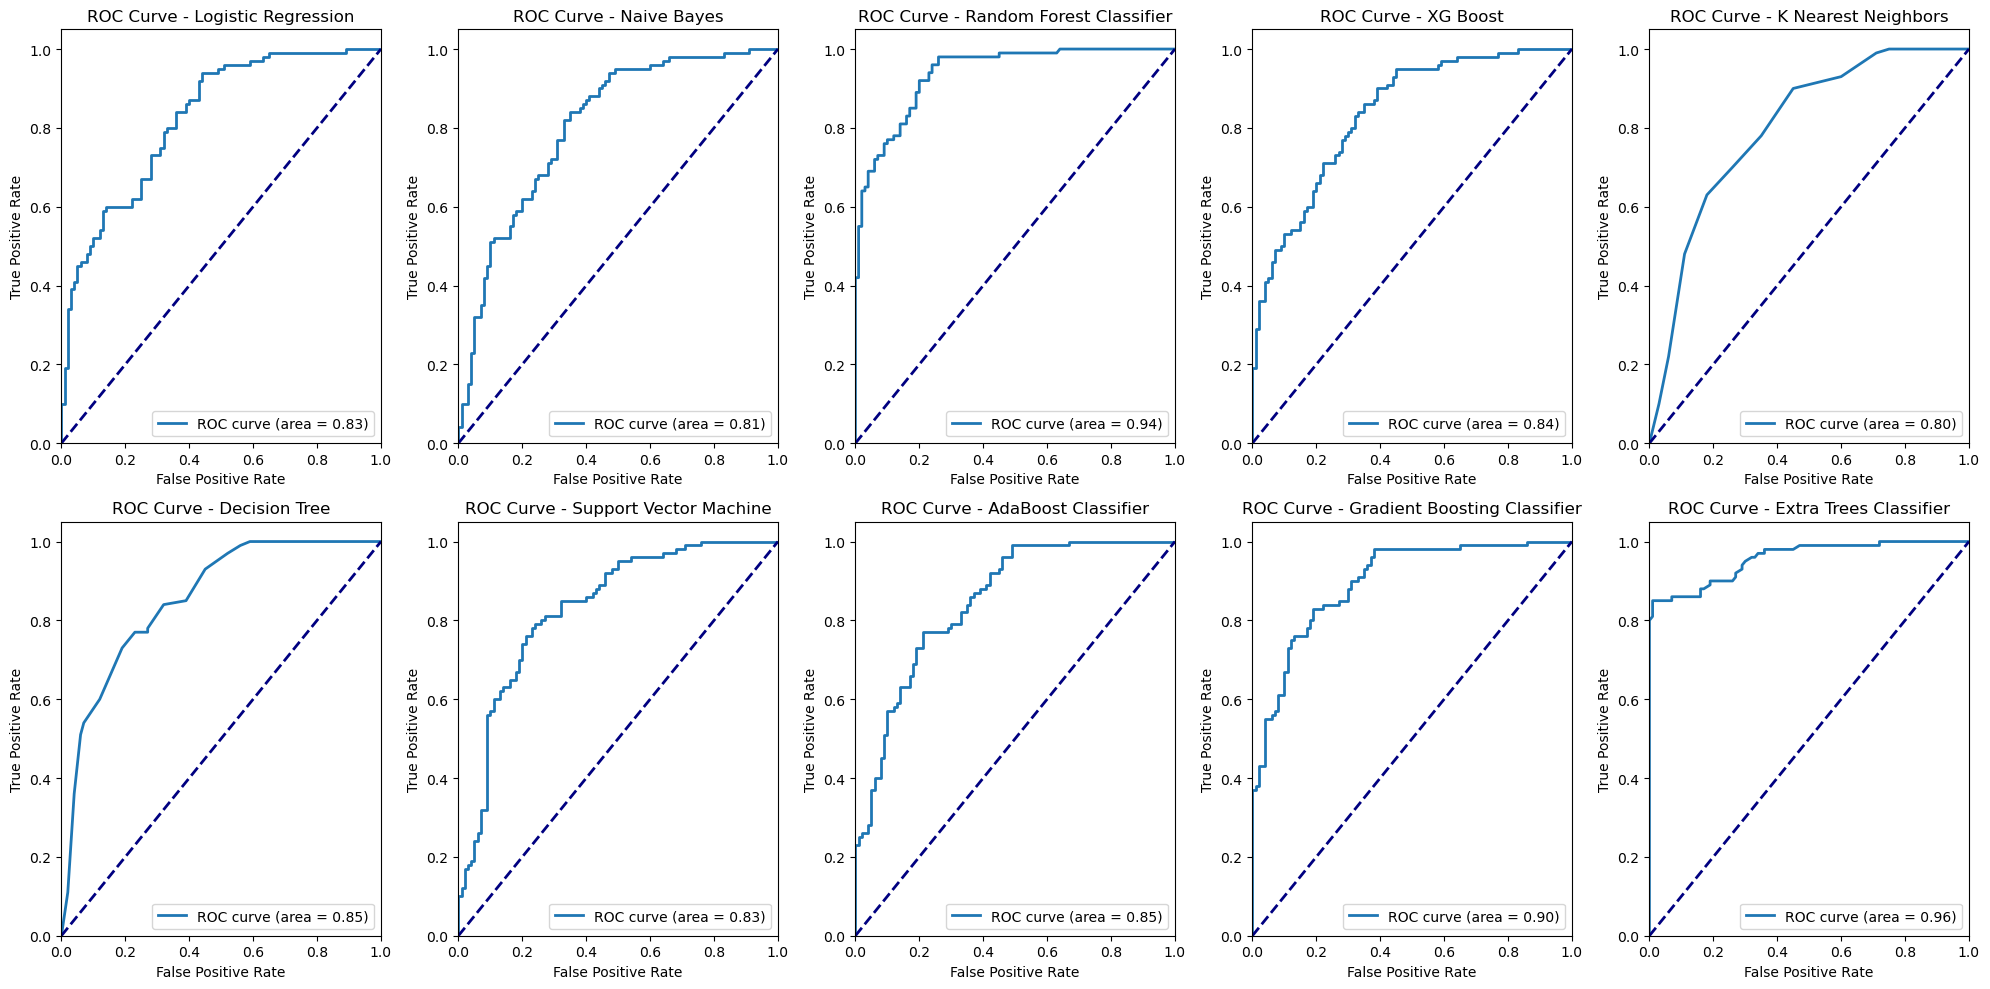

In [29]:
def plot_roc_curve(ax, y_true, y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    ax.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - ' + model_name)
    ax.legend(loc="lower right")

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()

for i, (model_name, model) in enumerate(models.items()):
    model.fit(x_train, y_train)
    y_score = model.predict_proba(x_test)[:, 1] 
    plot_roc_curve(axs[i], y_test, y_score, model_name)

plt.tight_layout()
plt.show()

In [23]:
best_model = models['Extra Trees Classifier']
pickle.dump(best_model,open('Diabetes_Model.pkl','wb'))
pickle.dump(scaler,open('Diabetes_Preprocessor.pkl','wb'))